## Programming Neural Networks from Scratch


In this exercise, you will implement a neural network to recognize handwritten digits using a training set from the well known MNIST hand written digit dataset. The neural network will be able to represent complex models that form non-linear hypotheses. For the first part of this homework, you will be using parameters from a neural network that is already trained. Your goal is to implement the feedforward propagation algorithm to use teh given weights for prediction. In the second part of the exercise, you will write the backpropagation algorithm for learning the neural network parameters.

We start by first loading and visualizing the dataset which contains the MNIST handwritten digits.

In [18]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

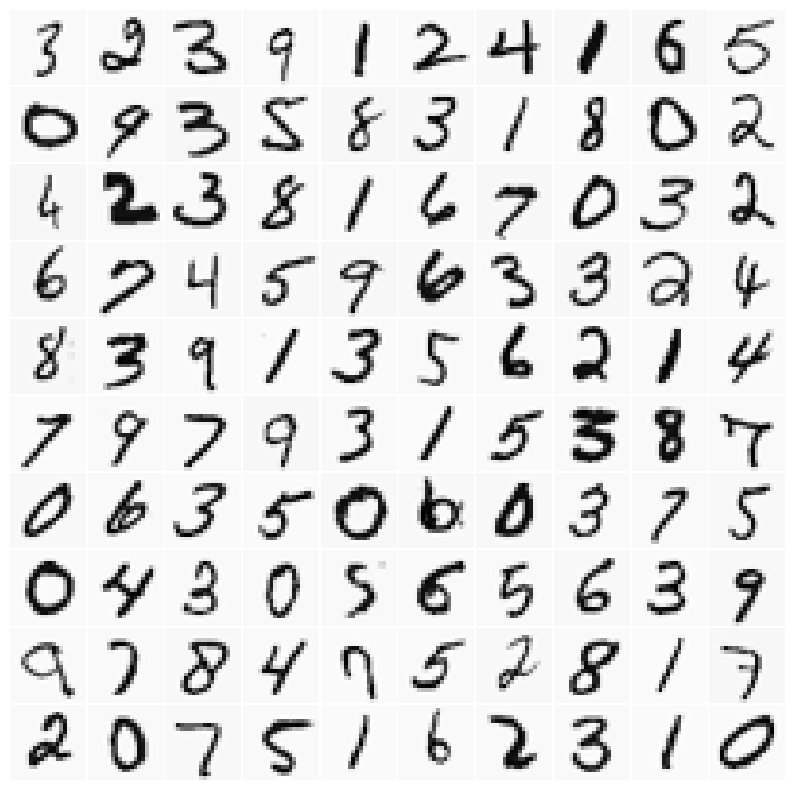

In [20]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'exdata1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

Model representation

Our neural network is shown in the following figure.

![Neural network](Figures/neuralnetwork.png)

It has 3 layers: an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). The training data will be loaded into the variables X and y.

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained. These are stored in `ex1weights.mat`. The following cell loads those parameters into  `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [22]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary
weights = loadmat(os.path.join('Data','ex1weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing,
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

<a id="section4"></a>
### Feedforward Propagation and Prediction

Now you will implement feedforward propagation for the neural network. You will need to complete the code in the function `predict` to return the neural network’s prediction. You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $\left( h_\theta(x) \right)_k$.

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows. When you complete the code in the function `predict`, you will need to add the column of 1’s to the matrix. The matrices `Theta1` and `Theta2` contain the parameters for each unit in rows. Specifically, the first row of `Theta1` corresponds to the first hidden unit in the second layer. In `numpy`, when you compute $z^{(2)} = \theta^{(1)}a^{(1)}$, be sure that you index (and if necessary, transpose) $X$ correctly so that you get $a^{(l)}$ as a 1-D vector.
</div>
<a id="predict"></a>

In [24]:
import numpy as np
import utils

def predict(Theta1, Theta2, X):
    if X.ndim == 1:
        X = X[None]  # Promote to 2D

    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # Add bias unit to input layer
    X_bias = np.concatenate([np.ones((m, 1)), X], axis=1)  # shape: (m x 401)

    # Hidden layer
    z2 = X_bias @ Theta1.T
    a2 = utils.sigmoid(z2)
    a2_bias = np.concatenate([np.ones((m, 1)), a2], axis=1)  # shape: (m x 26)

    # Output layer
    z3 = a2_bias @ Theta2.T
    a3 = utils.sigmoid(z3)  # shape: (m x 10)

    # Prediction: index of the max value in each row
    p = np.argmax(a3, axis=1)

    return p


Once you are done, call your predict function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%.

In [26]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


After that, we will display images from the training set one at a time, while at the same time printing out the predicted label for the displayed image.

Run the following cell to display a single image the neural network's prediction. You can run the cell multiple time to see predictions for different images.

 the neural network's prediction. You can run the cell multiple time to see predictions for different images.

Neural Network Prediction: 5


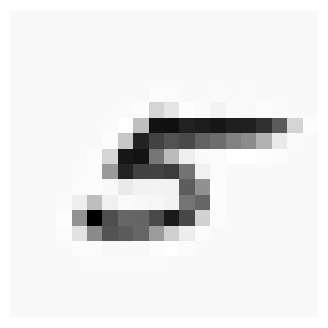

In [28]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

# Programming Neural Networks Learning

## Introduction

In this part of the exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. Before starting on the programming exercise, we strongly recommend reading and understanding the algorithm.


All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools.

In the previous part of the exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network. We will use the same dataset as the one we have used before and hence it is already loaded at this point.


### Visualizing the data

There are 5000 training examples in `exdata1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set.
The following cell randomly selects 100 images from the dataset and plots them.

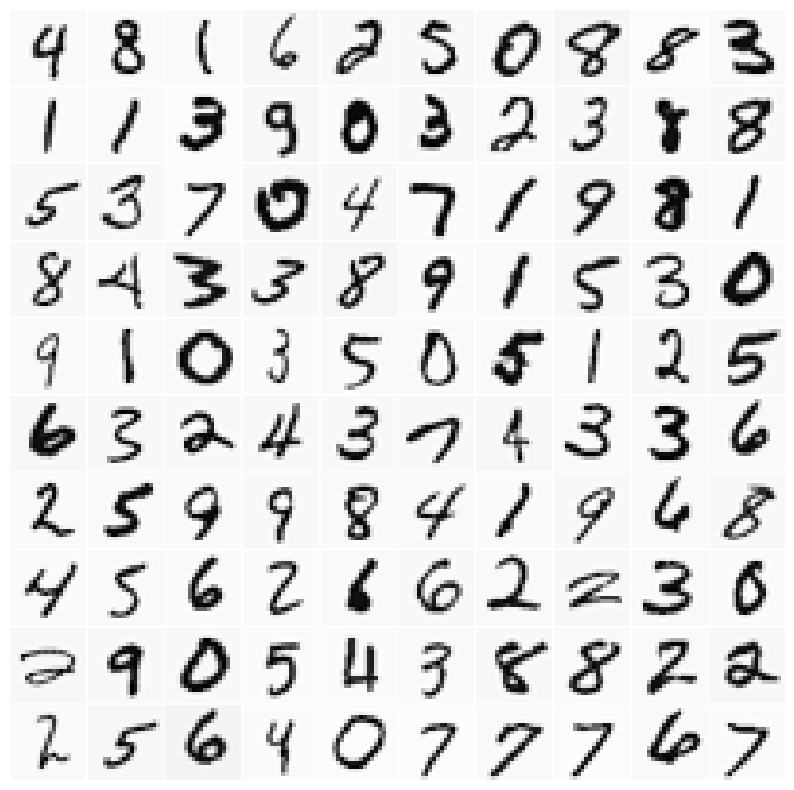

In [30]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

The neural network and the parameters are the same as described before for this part of the assignment as well. So you will use the same network architecture, the same parameters and the same weights that we have already loaded in the previous part of the assignment. We are repeating the following code here for recap.

In [32]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex1weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing,
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

<a id="section1"></a>
### Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

Let's assume the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y =
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows (i.e., X[i,:] is the i-th training example $x^{(i)}$, expressed as a $n \times 1$ vector.) When you complete the code in `nnCostFunction`, you will need to add the column of 1’s to the X matrix. The parameters for each unit in the neural network is represented in Theta1 and Theta2 as one row. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.
</div>
<a id="nnCostFunction"></a>

In [34]:
import numpy as np
import utils

# sigmoid gradients function is missing in the utils.py, so I just wrote the function here

def sigmoid_gradient(z):
    s = utils.sigmoid(z)
    return s * (1 - s)


def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):

    # Unroll params
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, input_layer_size + 1))

    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],
                        (num_labels, hidden_layer_size + 1))

    m = X.shape[0]
    J = 0
    Theta1_grad = np.zeros_like(Theta1)
    Theta2_grad = np.zeros_like(Theta2)

    # ========== Part 1: Feedforward ==========
    # Add bias unit to input layer
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)  # (m x 401)
    z2 = a1 @ Theta1.T
    a2 = utils.sigmoid(z2)

    # Add bias unit to hidden layer
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)  # (m x 26)
    z3 = a2 @ Theta2.T
    a3 = utils.sigmoid(z3)  # (m x 10)

    # One-hot encode y
    y_matrix = np.zeros((m, num_labels))
    for i in range(m):
        y_matrix[i, y[i] % 10] = 1

    # Compute cost
    term1 = -y_matrix * np.log(a3)
    term2 = (1 - y_matrix) * np.log(1 - a3)
    J = (1 / m) * np.sum(term1 - term2)

    # Add regularization to cost
    reg = (lambda_ / (2 * m)) * (np.sum(np.square(Theta1[:, 1:])) +
                                 np.sum(np.square(Theta2[:, 1:])))
    J += reg

    # ========== Part 2: Backpropagation ==========
    delta3 = a3 - y_matrix  # (m x 10)
    delta2 = (delta3 @ Theta2[:, 1:]) * sigmoid_gradient(z2)  # (m x 25)

    Delta1 = delta2.T @ a1  # (25 x 401)
    Delta2 = delta3.T @ a2  # (10 x 26)

    Theta1_grad = Delta1 / m
    Theta2_grad = Delta2 / m

    # ========== Part 3: Regularize Gradients ==========
    Theta1_grad[:, 1:] += (lambda_ / m) * Theta1[:, 1:]
    Theta2_grad[:, 1:] += (lambda_ / m) * Theta2[:, 1:]

    # Unroll gradients
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad


Once you are done, call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the cost is about 0.287629.

In [36]:
cost, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0)
print(f"Cost with lambda=1.0: {cost:.4f}")


Cost with lambda=1.0: 0.2876
